# Rede com contração e expansão - MNIST

## Importando módulos

In [1]:
%matplotlib inline

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Dataset

In [3]:
dataset_dir = './data/MNIST/processed/'

### Definição

In [4]:
# Background (non digit) label
keep_non_digit_label = False

In [5]:
def gaussianMap(H, W, sigma, mu):
    x, y = np.meshgrid(np.linspace(-1,1,W), np.linspace(-1,1,H))
    d = np.sqrt(x*x+y*y)
    return np.exp(-((d-mu)**2 / (2.0 * sigma**2)))

In [6]:
class GaussianMNIST(torch.utils.data.Dataset):
    def __init__(self, processed_data_dir, gauss_sigma=1.0, gauss_mu=0.0,
                 non_digit_label=True, numerical_label=False, split=(0.0, 1.0)):
        assert type(split) is tuple, 'Invalid split definition, must be tuple with starting/ending float'
        assert len(split) == 2, 'Invalid split definition, must be tuple with starting/ending float'
        assert (type(split[0]) is float) and (type(split[1]) is float), 'Invalid split definition,\
                                                                         must be tuple with starting/ending float'

        self.non_digit_label = non_digit_label
        self.numerical_label = numerical_label

        test_data, test_label = torch.load(os.path.join(processed_data_dir, 'test.pt'))
        train_data, train_label = torch.load(os.path.join(processed_data_dir, 'training.pt'))

        W = test_data[0].shape[0]
        H = test_data[0].shape[1]
        total_len = len(test_data) + len(train_data)
        start_idx = int(np.ceil(total_len * split[0]))
        end_idx = int(np.ceil(total_len * split[1]))

        self.data = torch.cat((train_data, test_data), dim=0)[start_idx:end_idx].type(torch.FloatTensor) / 255.0
        self.label = torch.cat((train_label, test_label), dim=0)[start_idx:end_idx]

        self.digit_gauss = torch.from_numpy(gaussianMap(H, W, gauss_sigma, gauss_mu)).type(torch.FloatTensor)
        self.non_digit_gauss = 1.0 - self.digit_gauss

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_data = self.data[index].unsqueeze(0)
        
        if self.non_digit_label:
            label_matrix = torch.zeros((11, 28, 28), dtype=torch.float)
            label_matrix[-1] = self.non_digit_gauss
            label_matrix[self.label[index].item()] = self.digit_gauss
        else:
            label_matrix = torch.stack([self.non_digit_gauss / 9.0] * 10, dim=0)
            label_matrix[self.label[index].item()] = 1.0 - (label_matrix[:9].sum(dim=0))

        if self.numerical_label:
            return image_data, label_matrix, self.label[index]
        else:
            return image_data, label_matrix

### Visualização de exemplo

In [7]:
def vizGaussNumber(gauss_image_tensor):
    num_cols = 4

    fig = plt.figure(figsize=(20, 20), edgecolor='black')

    num_imgs = gauss_image_tensor.shape[0]
    num_rows = int(np.ceil(num_imgs/num_cols))

    titles = ['digit'] + list(map(str, range(10)))
    if num_imgs == 12:
        titles += ['background']

    for idx in range(num_imgs):
        ax = fig.add_subplot(num_rows, num_cols, 1 + idx)
        ax.imshow(gauss_image_tensor[idx], cmap='gray')
        ax.set_title(titles[idx])
    plt.show()

In [8]:
def verifySum(gauss_image_tensor):
    gauss_image_tensor_sum = gauss_image_tensor[1:].sum(dim=0)
    print(f'Soma das probabilidades por pixel com valor 1: {torch.sum(gauss_image_tensor_sum == 1.0)}/{28*28}')

In [9]:
non_digit_gauss_dataset = GaussianMNIST(dataset_dir, gauss_sigma=0.8, non_digit_label=keep_non_digit_label)

non_digit_data_tensor, non_digit_label_tensor = non_digit_gauss_dataset[0]
non_digit_gauss_image_tensor = torch.cat((non_digit_data_tensor, non_digit_label_tensor), dim=0)

Soma das probabilidades por pixel com valor 1: 396/784


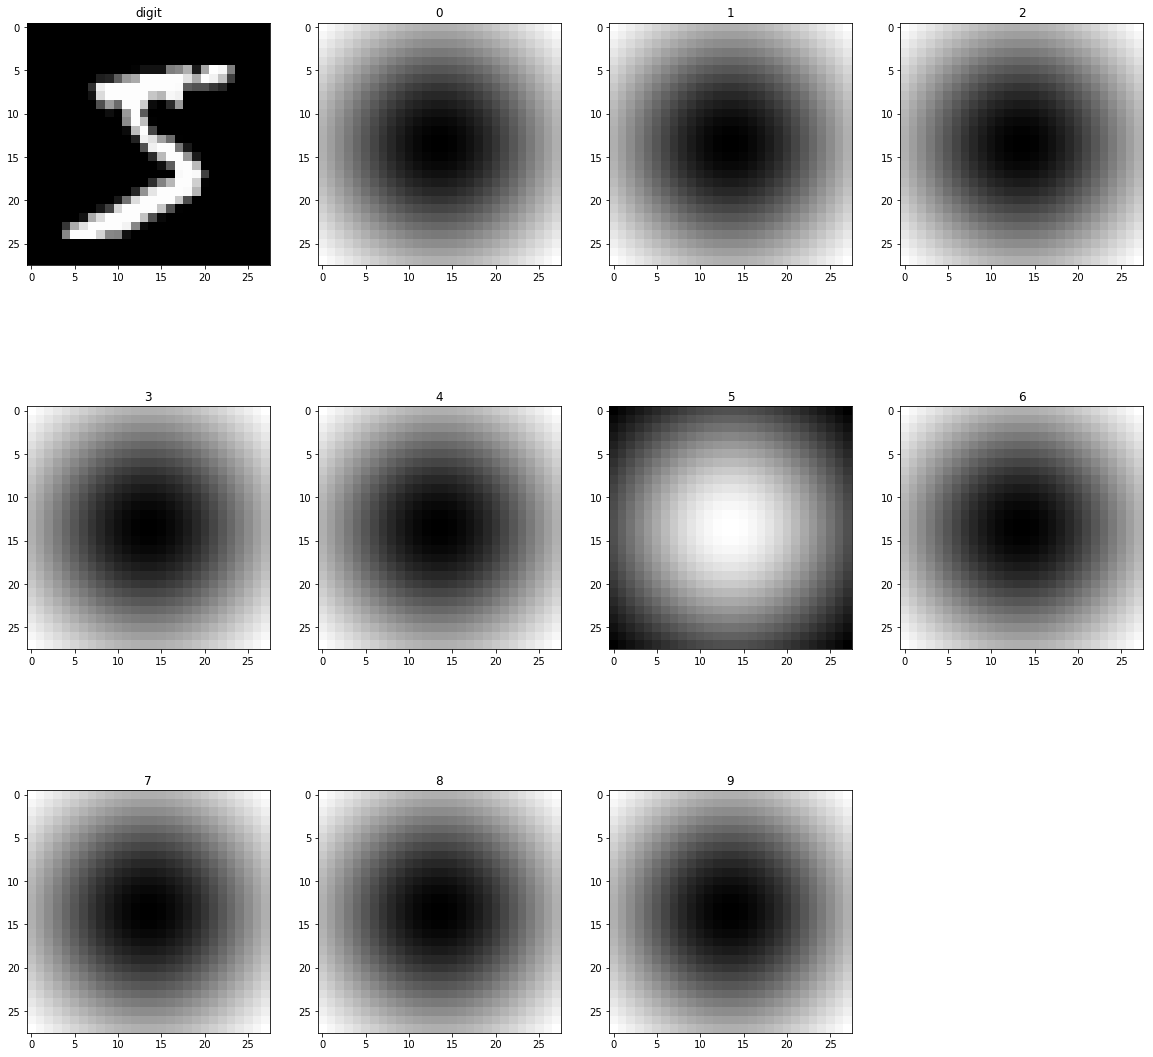

In [10]:
verifySum(non_digit_gauss_image_tensor)
vizGaussNumber(non_digit_gauss_image_tensor)

### Criação dos datasets de Treinamento, Validação e Teste

In [11]:
dataset_train = GaussianMNIST(dataset_dir, gauss_sigma=0.6, split=(0.0, 0.7), non_digit_label=keep_non_digit_label)
dataset_valid = GaussianMNIST(dataset_dir, gauss_sigma=0.6, split=(0.7, 0.9), non_digit_label=keep_non_digit_label)
dataset_test = GaussianMNIST(dataset_dir, gauss_sigma=0.6, split=(0.9, 1.0),
                             numerical_label=True, non_digit_label=keep_non_digit_label)

In [12]:
print(f'Número de amostras para treinamento: {len(dataset_train)}')
print(f'Número de amostras para validação: {len(dataset_valid)}')
print(f'Número de amostras para teste: {len(dataset_test)}')

Número de amostras para treinamento: 49000
Número de amostras para validação: 14000
Número de amostras para teste: 7000


## Dataloaders

In [13]:
batch_size = 64

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
}

## Definição do modelo de Rede Neural

In [14]:
class MyModelContractExpand(torch.nn.Module):
    def __init__(self, output_size=11):
        super(MyModelContractExpand, self).__init__()

        channel_array = np.array([2, 4, 6, 8, 7, 5, 3, 1]) * output_size

        self.ce = torch.nn.Sequential(OrderedDict([                                               # 1  x 28 x 28
            ('conv1', torch.nn.Conv2d(in_channels=1,
                                      out_channels=channel_array[0], kernel_size=3)),             # 2*os x 26 x 26
            ('relu1', torch.nn.ReLU()),
            ('conv2', torch.nn.Conv2d(in_channels=channel_array[0],
                                      out_channels=channel_array[1], kernel_size=3)),             # 4*os x 24 x 24
            ('relu2', torch.nn.ReLU()),
            ('conv3', torch.nn.Conv2d(in_channels=channel_array[1],
                                      out_channels=channel_array[2], kernel_size=3)),             # 6*os x 22 x 22
            ('relu3', torch.nn.ReLU()),
            ('conv4', torch.nn.Conv2d(in_channels=channel_array[2],
                                      out_channels=channel_array[3], kernel_size=3)),             # 8*os x 20 x 20
            ('relu4', torch.nn.ReLU()),
            ('transp4', torch.nn.ConvTranspose2d(in_channels=channel_array[3],
                                                 out_channels=channel_array[4], kernel_size=3)),  # 7*os x 22 x 22
            ('relu5', torch.nn.ReLU()),
            ('transp3', torch.nn.ConvTranspose2d(in_channels=channel_array[4],
                                                 out_channels=channel_array[5], kernel_size=3)),  # 5*os x 24 x 24
            ('relu6', torch.nn.ReLU()),
            ('transp2', torch.nn.ConvTranspose2d(in_channels=channel_array[5],
                                                 out_channels=channel_array[6], kernel_size=3)),  # 3*os x 26 x 26
            ('relu7', torch.nn.ReLU()),
            ('transp1', torch.nn.ConvTranspose2d(in_channels=channel_array[6],
                                                 out_channels=channel_array[7], kernel_size=3)),  # 1*os x 28 x 28
            ('softmax', torch.nn.Softmax2d())
        ]))

    def forward(self, x):
        x = self.ce(x)

        return x

### Observando a saida de cada camada

In [15]:
if keep_non_digit_label:
    model_output_size = 11
else:
    model_output_size = 10

model_ce = MyModelContractExpand(output_size=model_output_size).to(device)
x = torch.autograd.Variable(torch.zeros(1, 1, 28, 28)).to(device)

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_ce.ce.named_children():
    x = layer(x)

    print('{:10}: {}'.format(name, str(x.size())))

input     : torch.Size([1, 1, 28, 28])
conv1     : torch.Size([1, 20, 26, 26])
relu1     : torch.Size([1, 20, 26, 26])
conv2     : torch.Size([1, 40, 24, 24])
relu2     : torch.Size([1, 40, 24, 24])
conv3     : torch.Size([1, 60, 22, 22])
relu3     : torch.Size([1, 60, 22, 22])
conv4     : torch.Size([1, 80, 20, 20])
relu4     : torch.Size([1, 80, 20, 20])
transp4   : torch.Size([1, 70, 22, 22])
relu5     : torch.Size([1, 70, 22, 22])
transp3   : torch.Size([1, 50, 24, 24])
relu6     : torch.Size([1, 50, 24, 24])
transp2   : torch.Size([1, 30, 26, 26])
relu7     : torch.Size([1, 30, 26, 26])
transp1   : torch.Size([1, 10, 28, 28])
softmax   : torch.Size([1, 10, 28, 28])


## Treinamento

In [16]:
n_epochs = 600

optm = torch.optim.Adam(params=model_ce.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
crit = torch.nn.MSELoss()

In [17]:
def train_session(model, dataloaders, num_epochs, optimizer, criterion):
    num_train_samples = len(dataloaders['train'].dataset)
    num_valid_samples = len(dataloaders['valid'].dataset)
    train_batch_size = dataloaders['train'].batch_size
    valid_batch_size = dataloaders['valid'].batch_size

    num_train_batches = num_train_samples // train_batch_size
    num_valid_batches = num_valid_samples // valid_batch_size

    batch_print_size = 10

    epoch_train_loss_history = list()
    epoch_valid_loss_history = list()
    print('Start training for {} epochs'.format(num_epochs))

    try:
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            train_t0 = time.time()
            epoch_train_loss = 0.0
            running_loss = 0.0

            for i, samples in enumerate(dataloaders['train']):
                # get the inputs
                images = samples[0].to(device)
                labels = samples[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model_ce(images)
                loss = criterion(outputs, labels)
                loss_value = loss.cpu().item()
                loss.backward()
                optimizer.step()

                # Update loss totals
                running_loss += loss_value
                epoch_train_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

            epoch_train_loss /= num_train_samples
            train_t1 = time.time() - train_t0


            valid_t0 = time.time()
            epoch_valid_loss = 0.0
            running_loss = 0.0

            with torch.no_grad():
                for i, samples in enumerate(dataloaders['valid']):
                    # get the inputs
                    images = samples[0].to(device)
                    labels = samples[1].to(device)

                    # forward
                    outputs = model_ce(images)
                    loss = criterion(outputs, labels)
                    loss_value = loss.cpu().item()

                    # Update loss totals
                    running_loss += loss_value
                    epoch_valid_loss += loss_value

                    # print statistics
                    if i % batch_print_size == (batch_print_size - 1):
                        print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                        running_loss = 0.0

            epoch_valid_loss /= num_valid_samples
            valid_t1 = time.time() - valid_t0

            epoch_train_loss_history.append(epoch_train_loss)
            epoch_valid_loss_history.append(epoch_valid_loss)

            print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

        print('Finished Training')
    except KeyboardInterrupt:
        print('Finished by user')
        
    return epoch_train_loss_history, epoch_valid_loss_history

In [18]:
def save_loss_history(loss_history_list, loss_history_filename):
    file_obj = open(loss_history_filename, 'w')
    for entry in loss_history_list:
        file_obj.write(str(entry) + '\n')
    file_obj.close()

def load_loss_history(loss_history_filename):
    loss_history_list = list()

    file_obj = open(loss_history_filename, 'r')
    for line in file_obj:
        loss_history_list.append(float(line.strip()))
    file_obj.close()

    return loss_history_list

In [19]:
train = False
epoch_train_loss_history_filename = 'epoch_train_loss_history.txt'
epoch_valid_loss_history_filename = 'epoch_valid_loss_history.txt'

In [20]:
if train:
    epoch_train_loss_history, epoch_valid_loss_history = train_session(model_ce, dataloaders, n_epochs, optm, crit)
    torch.save(model_ce.state_dict(), './model/model_ce')
    save_loss_history(epoch_train_loss_history, epoch_train_loss_history_filename)
    save_loss_history(epoch_valid_loss_history, epoch_valid_loss_history_filename)
else:
    model_ce.load_state_dict(torch.load('./model/model_ce'))
    epoch_train_loss_history = load_loss_history(epoch_train_loss_history_filename)
    epoch_valid_loss_history = load_loss_history(epoch_valid_loss_history_filename)

### Evolução do treinamento

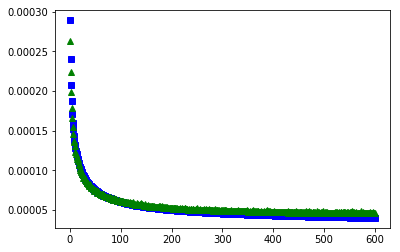

In [21]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Cálculo da acurácia no conjunto de testes

In [22]:
test_loss = list()
test_label = list()
test_output = list()
test_output_sum = list()

with torch.no_grad():
    for i, samples in enumerate(dataset_test):
        # get the inputs
        image = samples[0].unsqueeze(0).to(device)
        gauss_label = samples[1].unsqueeze(0).to(device)
        test_label.append(samples[2].item())

        # forward
        outputs = model_ce(image)
        loss = crit(outputs, gauss_label)

        test_loss.append(loss.cpu().item())
        test_output.append(outputs.cpu())
        test_output_sum.append(outputs.sum(dim=2).sum(dim=2)[0].cpu().numpy())

In [23]:
test_label_array = np.array(test_label)
test_loss_array = np.array(test_loss)
test_loss_idx = np.argsort(test_loss_array)
test_output_sum_idx = np.array([np.argmax(entry) for entry in test_output_sum])

In [24]:
num_correct_samples = np.sum(test_output_sum_idx == test_label_array)
print(f'Acurácia (pela soma por camada do label): {num_correct_samples * 100.0 / len(test_label_array)}%')

Acurácia (pela soma por camada do label): 99.57142857142857%


### Exemplo com menor perda

In [25]:
image_gauss_output = torch.cat((dataset_test[test_loss_idx[0]][0], test_output[test_loss_idx[0]][0]), dim=0)

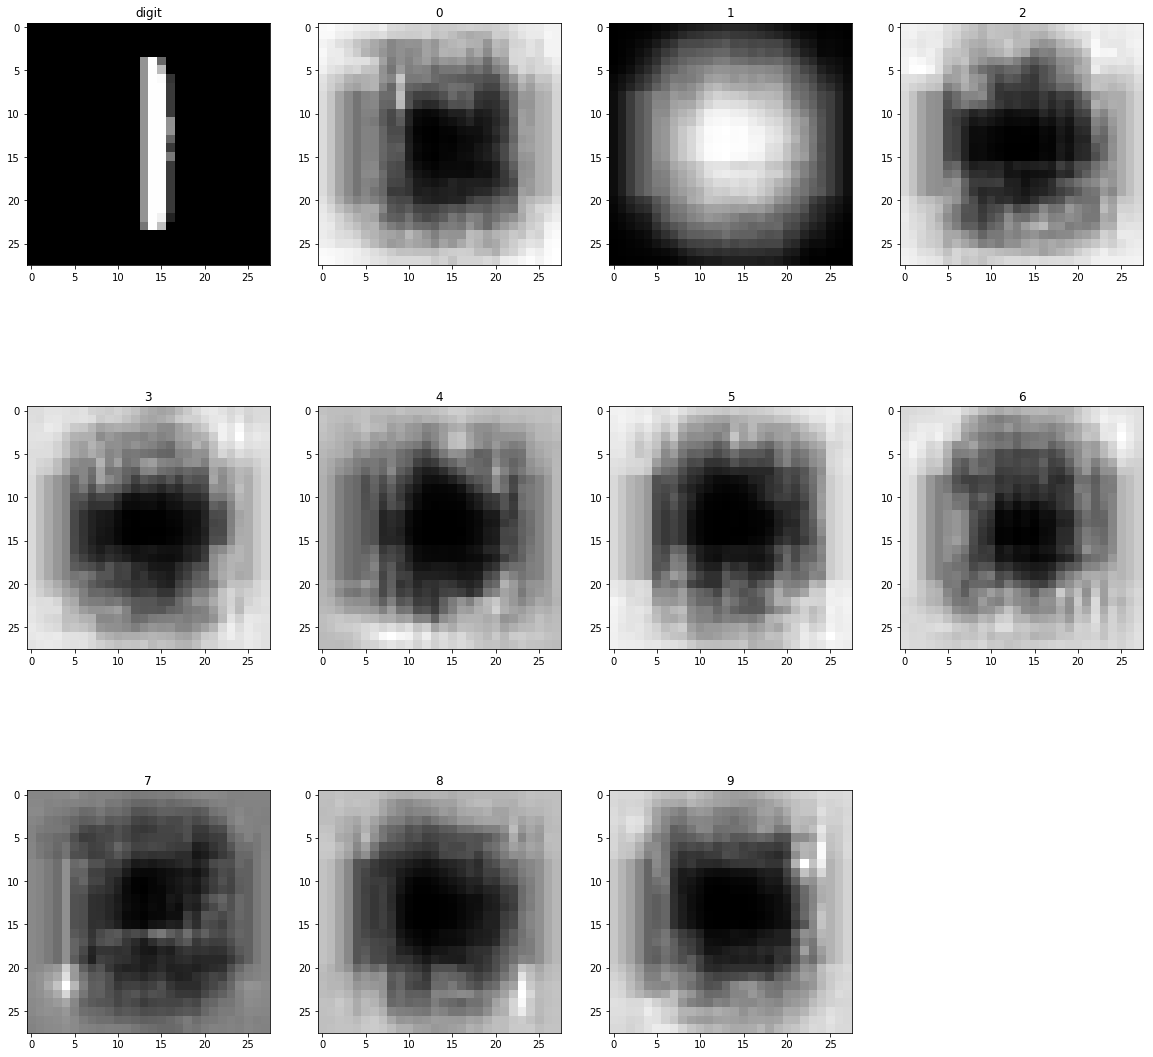

In [26]:
vizGaussNumber(image_gauss_output)

### Exemplo com maior perda

In [27]:
image_gauss_output = torch.cat((dataset_test[test_loss_idx[-1]][0], test_output[test_loss_idx[-1]][0]), dim=0)

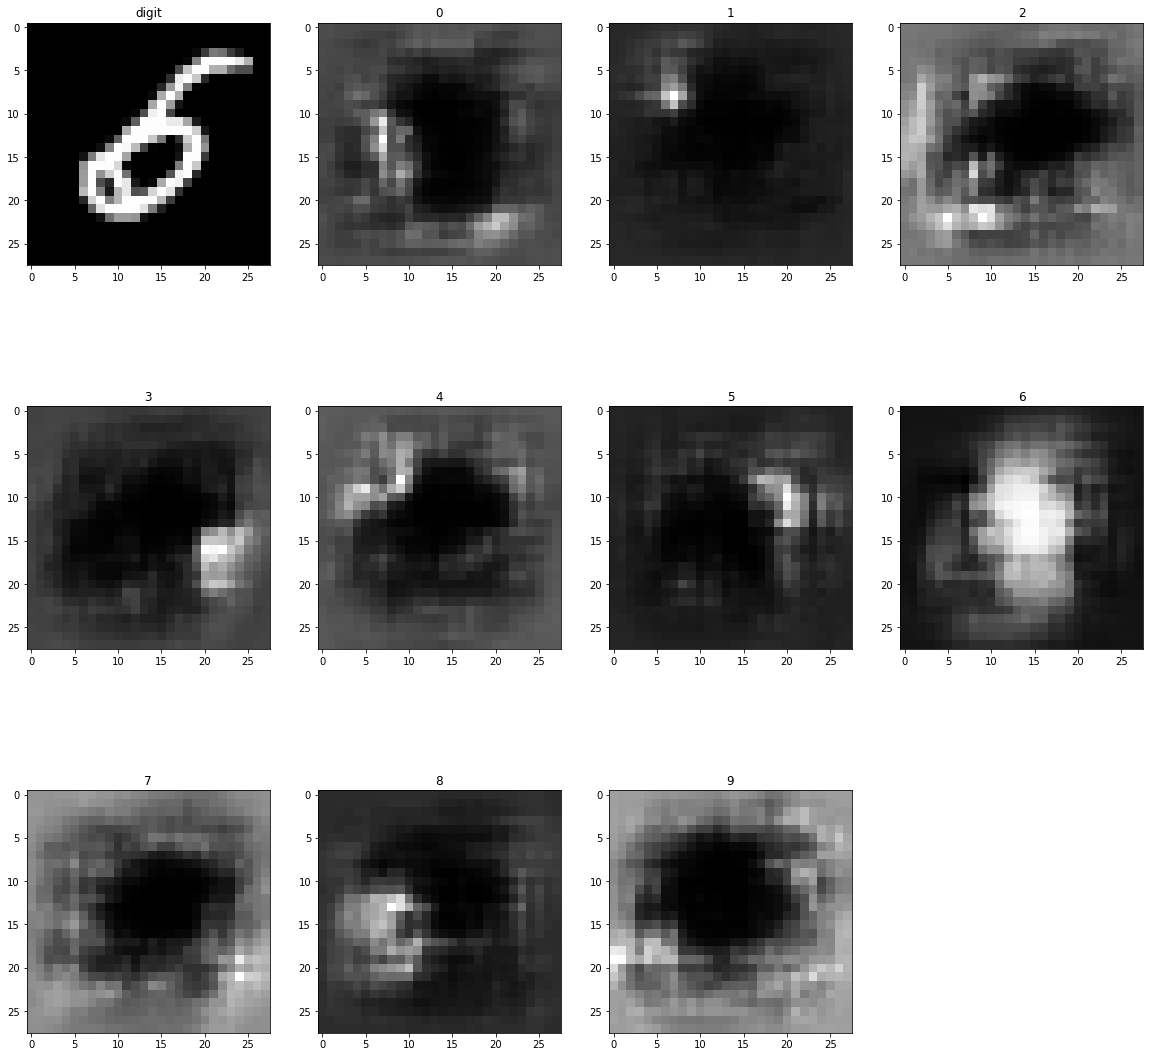

In [28]:
vizGaussNumber(image_gauss_output)

## Predição sobre imagem ampliada com vários dígitos

In [29]:
def matrixMNIST(dataset, output_size, num_h=10, num_w=10, num_digits=10):
    num_cells = num_h * num_w
    cell_indices = np.arange(num_cells)
    np.random.shuffle(cell_indices)
    cell_indices = cell_indices[:np.minimum(num_digits, num_cells)]

    digits_indices = np.arange(len(dataset))
    np.random.shuffle(cell_indices)
    digits_indices = digits_indices[:np.minimum(num_digits, num_cells)]

    matrix_image = torch.zeros((num_h * 28, num_w * 28), dtype=torch.float)
    if output_size == 10:
        matrix_label = torch.ones((output_size, num_h * 28, num_w * 28), dtype=torch.float) / 10.0
    else:
        matrix_label = torch.zeros((output_size, num_h * 28, num_w * 28), dtype=torch.float)
        matrix_label[-1] = 1.0

    for idx in range(len(cell_indices)):
        cell_row = cell_indices[idx] // num_w
        cell_col = cell_indices[idx] % num_w

        sample = dataset[digits_indices[idx]]
        digit_image = sample[0]
        digit_label = sample[1]

        cell_row_start = cell_row * 28
        cell_row_end = cell_row_start + 28
        cell_col_start = cell_col * 28
        cell_col_end = cell_col_start + 28

        matrix_image[cell_row_start:cell_row_end, cell_col_start:cell_col_end] = digit_image[0]
        matrix_label[:, cell_row_start:cell_row_end, cell_col_start:cell_col_end] = digit_label[:]

    return matrix_image, matrix_label

In [30]:
num_h=10
num_w=10

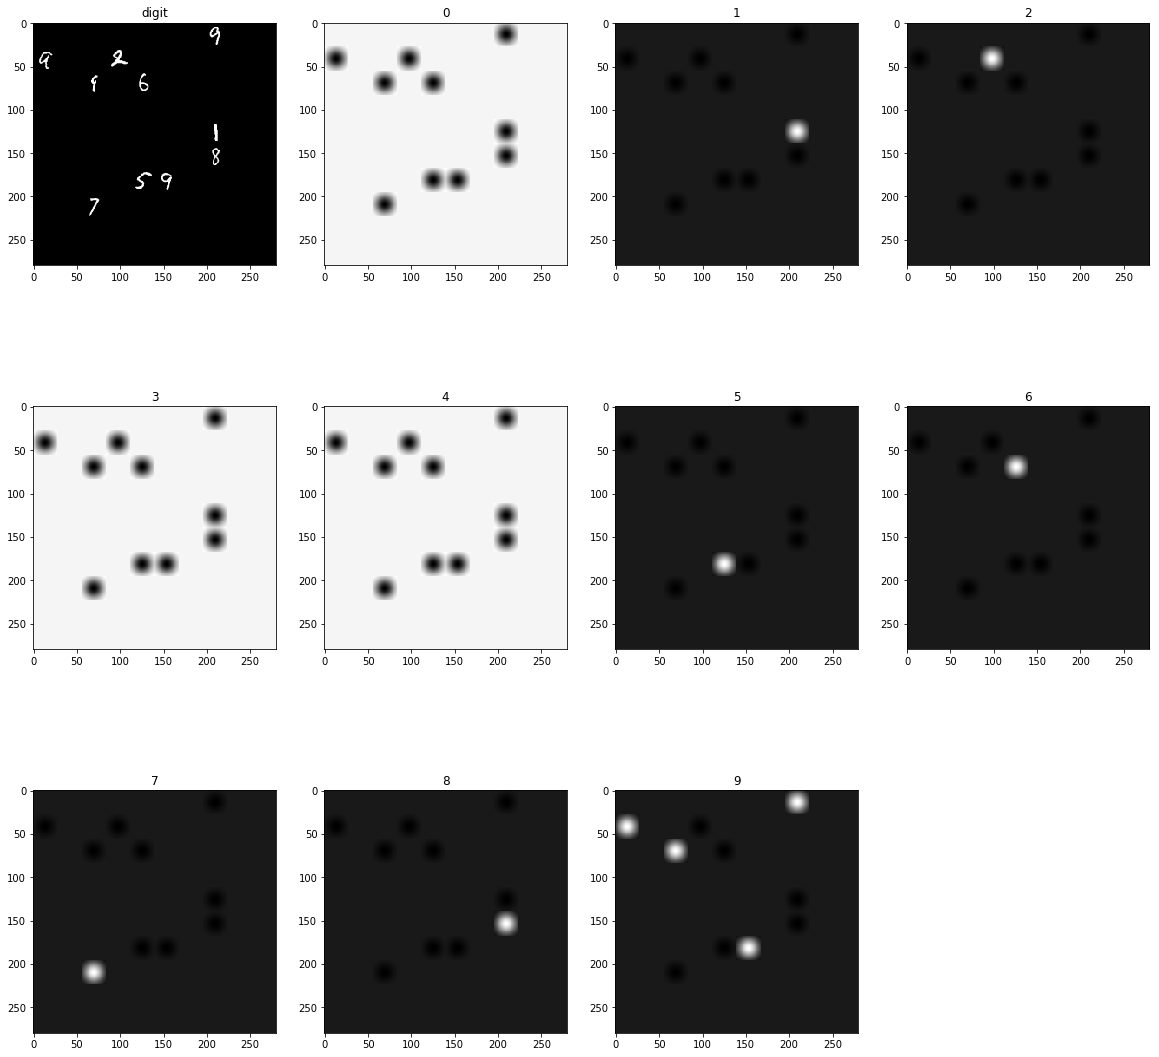

In [31]:
matrix_image, matrix_label = matrixMNIST(dataset_test, model_output_size, num_h=num_h, num_w=num_w)
matrix_image = matrix_image.unsqueeze(0)
matrix_image_gauss_tensor = torch.cat((matrix_image, matrix_label), dim=0)
vizGaussNumber(matrix_image_gauss_tensor)

In [32]:
matrix_image = matrix_image.unsqueeze(0).to(device)
matrix_label = matrix_label.unsqueeze(0).to(device)

with torch.no_grad():
    # forward
    matrix_outputs = model_ce(matrix_image)
    loss = crit(matrix_outputs, matrix_label)

    print(f'Valor da perda: {loss.cpu().item()}')

Valor da perda: 0.016124773770570755


In [33]:
matrix_image = matrix_image.cpu()[0]
matrix_outputs = matrix_outputs.cpu()[0]

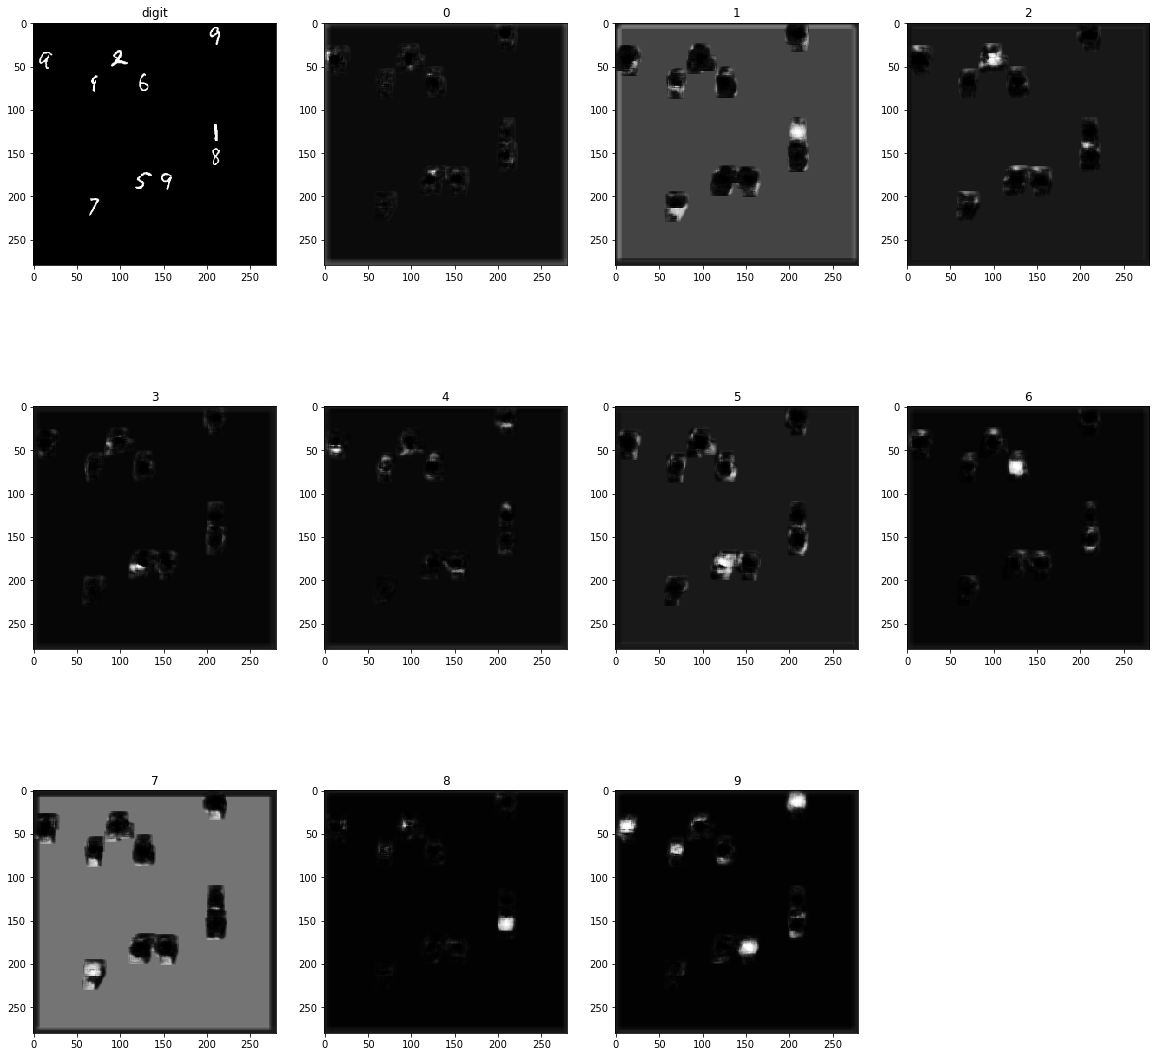

In [34]:
outputs_matrix_image_gauss_tensor = torch.cat((matrix_image, matrix_outputs), dim=0)
vizGaussNumber(outputs_matrix_image_gauss_tensor)

### Determinação de bounding boxes

In [35]:
matrix_outputs_array = matrix_outputs.numpy()

In [36]:
H = num_h * 28
W = num_w * 28
delta_dim = 28 // 2

matrix_outputs_bbox_label = np.empty((H, W), dtype='uint8')
matrix_outputs_bbox_sum = np.empty((H, W), dtype='float')

for row in range(H):
    row_start = np.maximum(0, row - delta_dim)
    row_end = np.minimum(H, row + delta_dim)

    for col in range(W):
        col_start = np.maximum(0, col - delta_dim)
        col_end = np.minimum(H, col + delta_dim)

        matrix_outputs_sum = np.sum(matrix_outputs_array[:, row_start:row_end, col_start:col_end], axis=(1, 2))
        matrix_outputs_bbox_label[row, col] = np.argmax(matrix_outputs_sum, axis=0)
        matrix_outputs_bbox_sum[row, col] = matrix_outputs_sum[matrix_outputs_bbox_label[row, col]]

bbox_threshold = 1
bbox_delta = np.array([[[delta_dim]],[[delta_dim]]])
matrix_outputs_bbox_idx = np.meshgrid(np.linspace(0,W-1,W), np.linspace(0,H-1,H))
matrix_outputs_bbox_start = np.maximum(0, matrix_outputs_bbox_idx - bbox_delta)
matrix_outputs_bbox_end = np.array([np.minimum(W, matrix_outputs_bbox_idx[0] + bbox_delta[0]),
                                    np.minimum(H, matrix_outputs_bbox_idx[1] + bbox_delta[1])])

for row in range(H):
    row_start = np.maximum(0, row - delta_dim)
    row_end = np.minimum(H, row + delta_dim)

    for col in range(W):
        col_start = np.maximum(0, col - delta_dim)
        col_end = np.minimum(H, col + delta_dim)


In [37]:
print(matrix_outputs_bbox_sum[42])

[130.34613037 144.34933472 158.21231079 171.12794495 184.11303711
 195.68748474 205.97232056 216.28038025 224.2290802  229.66598511
 233.88973999 235.90362549 237.08003235 237.77148438 238.13433838
 235.49403381 232.76101685 229.57504272 225.26342773 221.16029358
 214.8631897  205.0083313  192.36782837 179.71159363 166.63287354
 170.65164185 180.90464783 191.5067749  202.37797546 213.14067078
 223.9259491  234.32975769 244.79910278 254.70524597 264.62805176
 274.35626221 283.57537842 292.79162598 302.44836426 310.28915405
 318.22375488 324.72735596 329.63598633 333.23040771 335.78155518
 337.02093506 337.02093506 337.02093506 337.01409912 336.95974731
 336.70666504 336.43365479 335.79125977 335.06213379 334.27664185
 333.36514282 332.43658447 331.43463135 330.42047119 329.39996338
 328.37792969 327.36633301 326.3503418  325.33157349 324.32858276
 323.35559082 322.54388428 321.88290405 321.46148682 320.22918701
 318.93685913 315.77688599 311.60534668 305.88803101 299.44381714
 291.81433